In [ ]:
!apt-get install -y \
    libgl1-mesa-dev \
    libgl1-mesa-glx \
    libglew-dev \
    libosmesa6-dev \
    software-properties-common

!apt-get install -y patchelf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
software-properties-common is already the newest version (0.99.22.9).
The following additional packages will be installed:
  libegl-dev libgl-dev libgles-dev libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev
  libglvnd-dev libglx-dev libopengl-dev libosmesa6
The following NEW packages will be installed:
  libegl-dev libgl-dev libgl1-mesa-dev libgl1-mesa-glx libgles-dev libgles1 libglew-dev
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev libopengl-dev libosmesa6
  libosmesa6-dev
0 upgraded, 15 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,020 kB of archives.
After this operation, 19.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libglx-dev amd64 1.4.0-1 [14.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgl-dev amd64 1.4.0-1 [101 kB]
Get:3 http://archive.ubuntu.com/ubuntu 

In [ ]:
!pip install free-mujoco-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 26.5 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10


In [ ]:
import mujoco_py
import gym

Compiling /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx because it changed.
[1/1] Cythonizing /usr/local/lib/python3.10/dist-packages/mujoco_py/cymj.pyx


INFO:root:running build_ext
INFO:root:building 'mujoco_py.cymj' extension
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-310/usr/local/lib
INFO:root:creating /usr/local/lib/python3.10/dist-packages/mujoco_py/generated/_pyxbld_2.0.2.13_310_linuxcpuextensionbuilder/temp.linux-x86_64-cpython-31

In [ ]:
!pip install mujoco

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 14.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Tokenizer
import gym

class Policy(nn.Module):
    def __init__(self,num_outputs):
        super(Policy, self).__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2Model.from_pretrained(model_name)

        # Define the policy head
        self.affine1 = nn.Linear(self.model.config.n_embd, 64)
        self.affine2 = nn.Linear(64, 64)
        self.action_mean = nn.Linear(64, num_outputs)
        self.action_mean.weight.data.mul_(0.1)
        self.action_mean.bias.data.mul_(0.0)

        self.action_log_std = nn.Parameter(torch.zeros(1, num_outputs))

    def forward(self, x):
        # Convert input tensor to a list of strings
        x_str = ' '.join(map(str, x.tolist()))
        inputs = self.tokenizer(x_str, return_tensors="pt")

        # Pass inputs through GPT-2
        outputs = self.model(**inputs)

        # Use the last hidden state of the last token
        last_hidden_state = outputs.last_hidden_state[:, -1, :]

        # Pass the GPT-2 features through the policy head
        x = torch.tanh(self.affine1(last_hidden_state))
        x = torch.tanh(self.affine2(x))
        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std


class Value(nn.Module):
    def __init__(self, num_inputs):
        super(Value, self).__init__()
        self.affine1 = nn.Linear(num_inputs, 64)
        self.affine2 = nn.Linear(64, 64)
        self.value_head = nn.Linear(64, 1)
        self.value_head.weight.data.mul_(0.1)
        self.value_head.bias.data.mul_(0.0)

    def forward(self, x):
        x = torch.tanh(self.affine1(x))
        x = torch.tanh(self.affine2(x))

        state_values = self.value_head(x)
        return state_values


In [ ]:
import math

import numpy as np

import torch


def normal_entropy(std):
    var = std.pow(2)
    entropy = 0.5 + 0.5 * torch.log(2 * var * math.pi)
    return entropy.sum(1, keepdim=True)


def normal_log_density(x, mean, log_std, std):
    var = std.pow(2)
    log_density = -(x - mean).pow(2) / (
        2 * var) - 0.5 * math.log(2 * math.pi) - log_std
    return log_density.sum(1, keepdim=True)


def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size


def get_flat_grad_from(net, grad_grad=False):
    grads = []
    for param in net.parameters():
        if grad_grad:
            grads.append(param.grad.grad.view(-1))
        else:
            grads.append(param.grad.view(-1))

    flat_grad = torch.cat(grads)
    return flat_grad


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import numpy as np

import torch
from torch.autograd import Variable
def conjugate_gradients(Avp, b, nsteps, residual_tol=1e-10):
    x = torch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    for i in range(nsteps):
        _Avp = Avp(p)
        alpha = rdotr / torch.dot(p, _Avp)
        x += alpha * p
        r -= alpha * _Avp
        new_rdotr = torch.dot(r, r)
        betta = new_rdotr / rdotr
        p = r + betta * p
        rdotr = new_rdotr
        if rdotr < residual_tol:
            break
    return x


def linesearch(model,
               f,
               x,
               fullstep,
               expected_improve_rate,
               max_backtracks=10,
               accept_ratio=.1):
    fval = f(True).data
    print("fval before", fval.item())
    for (_n_backtracks, stepfrac) in enumerate(.5**np.arange(max_backtracks)):
        xnew = x + stepfrac * fullstep
        set_flat_params_to(model, xnew)
        newfval = f(True).data
        actual_improve = fval - newfval
        expected_improve = expected_improve_rate * stepfrac
        ratio = actual_improve / expected_improve
        print("a/e/r", actual_improve.item(), expected_improve.item(), ratio.item())

        if ratio.item() > accept_ratio and actual_improve.item() > 0:
            print("fval after", newfval.item())
            return True, xnew
    return False, x


def trpo_step(model, get_loss, get_kl, max_kl, damping):
    loss = get_loss()
    grads = torch.autograd.grad(loss, model.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        kl = get_kl()
        kl = kl.mean()

        grads = torch.autograd.grad(kl, model.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * Variable(v)).sum()
        grads = torch.autograd.grad(kl_v, model.parameters())
        flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * damping

    stepdir = conjugate_gradients(Fvp, -loss_grad, 10)

    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)
    print(("lagrange multiplier:", lm[0], "grad_norm:", loss_grad.norm()))

    prev_params = get_flat_params_from(model)
    success, new_params = linesearch(model, get_loss, prev_params, fullstep,
                                     neggdotstepdir / lm[0])
    set_flat_params_to(model, new_params)

    return loss


In [ ]:
import random
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'mask', 'next_state',
                                       'reward'))


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)


In [ ]:
from collections import deque

import numpy as np


class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape


In [ ]:
import torch


def conjugate_gradients(Avp, b, nsteps, residual_tol=1e-10):
    x = torch.zeros(b.size())
    r = b - Avp(x)
    p = r
    rdotr = torch.dot(r, r)

    for i in range(nsteps):
        _Avp = Avp(p)
        alpha = rdotr / torch.dot(p, _Avp)
        x += alpha * p
        r -= alpha * _Avp
        new_rdotr = torch.dot(r, r)
        betta = new_rdotr / rdotr
        p = r + betta * p
        rdotr = new_rdotr
        if rdotr < residual_tol:
            break
    return x


def flat_grad_from(net, grad_grad=False):
    grads = []
    for param in net.parameters():
        if grad_grad:
            grads.append(param.grad.grad.view(-1))
        else:
            grads.append(param.grad.view(-1))

    flat_grad = torch.cat(grads)
    return flat_grad


In [ ]:
class Policy(nn.Module):
    def __init__(self, num_inputs, num_outputs,model_name='gpt2'):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(num_inputs, 64)
        self.affine2 = nn.Linear(64, 64)
        self.action_mean = nn.Linear(64, num_outputs)
        self.action_mean.weight.data.mul_(0.1)
        self.action_mean.bias.data.mul_(0.0)

        self.action_log_std = nn.Parameter(torch.zeros(1, num_outputs))

        self.saved_actions = []
        self.rewards = []
        self.final_value = 0

    def forward(self, x):
        x = torch.tanh(self.affine1(x))
        x = torch.tanh(self.affine2(x))
        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)


('lagrange multiplier:', tensor(0.6156), 'grad_norm:', tensor(0.0900))
fval before 9.96425164601078e-17
a/e/r 0.01211731592196585 0.012276700187628494 0.9870173366436642
fval after -0.01211731592196575
Episode 1	Last reward: -679.7614304263581	Average reward -618.65
('lagrange multiplier:', tensor(0.4593), 'grad_norm:', tensor(0.0530))
fval before -4.440892098500626e-19
a/e/r 0.009221434427911766 0.00913732640782086 1.0092048829533895
fval after -0.009221434427911766
Episode 2	Last reward: -575.8513520526836	Average reward -600.02
('lagrange multiplier:', tensor(0.5331), 'grad_norm:', tensor(0.0578))
fval before 4.440892098500626e-18
a/e/r 0.011071943031856338 0.010745813461552269 1.030349453903228
fval after -0.011071943031856333
Episode 3	Last reward: -599.7448614135028	Average reward -599.67
('lagrange multiplier:', tensor(0.5073), 'grad_norm:', tensor(0.0580))
fval before 5.3290705182007515e-18
a/e/r 0.010245488156422716 0.01011509012592946 1.0128914353574554
fval after -0.01024548

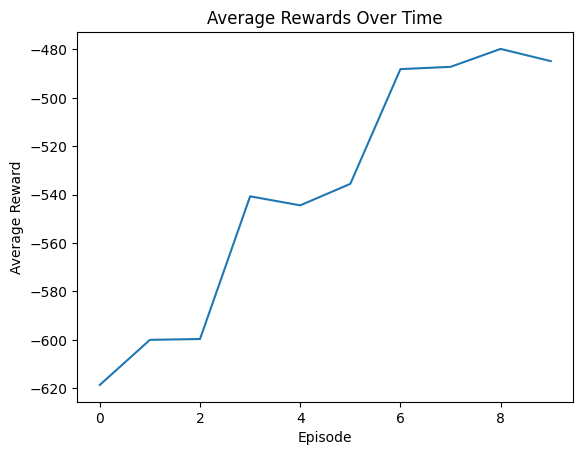

('lagrange multiplier:', tensor(0.6405), 'grad_norm:', tensor(0.0839))
fval before -3.26405569239796e-17
a/e/r 0.012855972762102843 0.012816664080233872 1.0030669979038924
fval after -0.012855972762102876
Episode 11	Last reward: -445.0118082993642	Average reward -447.67
('lagrange multiplier:', tensor(0.5635), 'grad_norm:', tensor(0.0680))
fval before 1.2212453270876722e-17
a/e/r 0.011310542981480199 0.011242413317459916 1.0060600568664804
fval after -0.011310542981480187
Episode 12	Last reward: -442.63069641609343	Average reward -427.84
('lagrange multiplier:', tensor(0.6505), 'grad_norm:', tensor(0.0834))
fval before -7.105427357601002e-18
a/e/r 0.012968843001933737 0.012963936671870147 1.0003784598912948
fval after -0.012968843001933744
Episode 13	Last reward: -305.597817204271	Average reward -410.01
('lagrange multiplier:', tensor(0.6105), 'grad_norm:', tensor(0.0798))
fval before 5.3290705182007515e-18
a/e/r 0.012142185902332615 0.012211522248052706 0.994322055488934
fval after -0

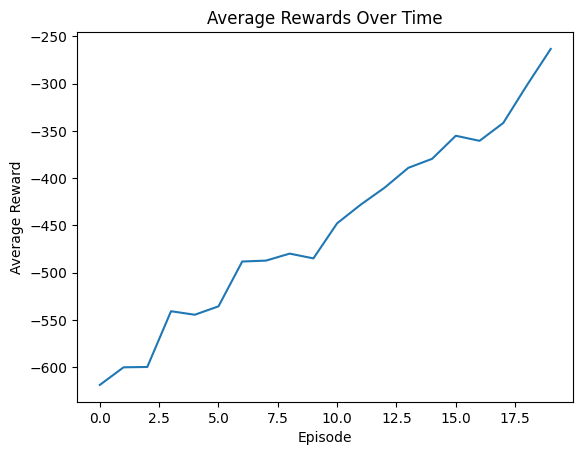

('lagrange multiplier:', tensor(0.6475), 'grad_norm:', tensor(0.0929))
fval before -5.773159728050814e-18
a/e/r 0.013040274661449525 0.013126563892433543 0.9934263656741307
fval after -0.01304027466144953
Episode 21	Last reward: -306.3547143995887	Average reward -243.51
('lagrange multiplier:', tensor(0.6261), 'grad_norm:', tensor(0.0919))
fval before 2.220446049250313e-18
a/e/r 0.012582021398420015 0.012607370186372114 0.9979893675225385
fval after -0.012582021398420013
Episode 22	Last reward: -239.44688566334526	Average reward -265.86
('lagrange multiplier:', tensor(0.6032), 'grad_norm:', tensor(0.0850))
fval before 7.327471962526034e-18
a/e/r 0.012169415336876158 0.012279273877679391 0.9910533357348655
fval after -0.012169415336876151
Episode 23	Last reward: -215.11482669340106	Average reward -212.81
('lagrange multiplier:', tensor(0.6247), 'grad_norm:', tensor(0.0862))
fval before 2.886579864025407e-18
a/e/r 0.012455361460525246 0.01256551632800319 0.9912335582078347
fval after -0.

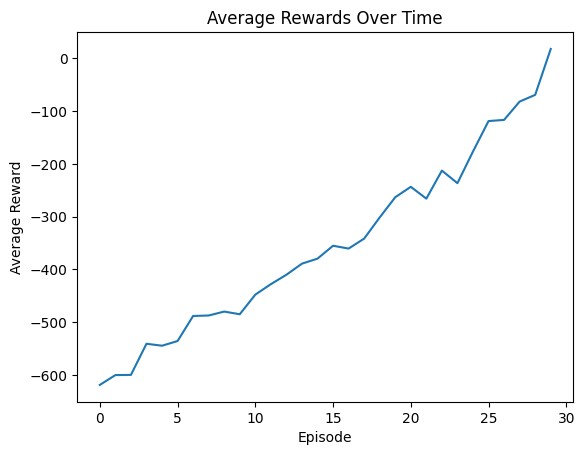

('lagrange multiplier:', tensor(0.6353), 'grad_norm:', tensor(0.0984))
fval before 1.6542323066914832e-17
a/e/r 0.012771962626027178 0.0129015021760715 0.989959343627087
fval after -0.01277196262602716
Episode 31	Last reward: 115.74692892069689	Average reward 19.07
('lagrange multiplier:', tensor(0.6622), 'grad_norm:', tensor(0.1077))
fval before -9.325873406851316e-18
a/e/r 0.013593373424227024 0.01361132666199493 0.9986810075010517
fval after -0.013593373424227033
Episode 32	Last reward: 7.023700427091688	Average reward 28.12
('lagrange multiplier:', tensor(0.6612), 'grad_norm:', tensor(0.1076))
fval before -3.663735981263017e-18
a/e/r 0.013783421485294482 0.013700220596687046 1.0060729597761042
fval after -0.013783421485294486
Episode 33	Last reward: 76.45954711532853	Average reward 91.96
('lagrange multiplier:', tensor(0.6748), 'grad_norm:', tensor(0.1132))
fval before 9.769962616701377e-18
a/e/r 0.0131686939957807 0.013162130324516744 1.0004986784891294
fval after -0.0131686939957

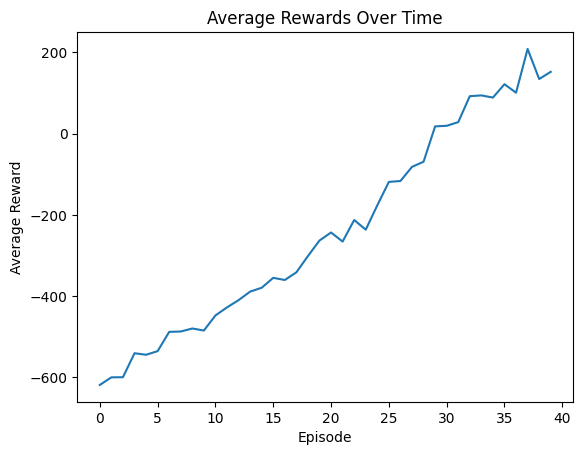

('lagrange multiplier:', tensor(0.7049), 'grad_norm:', tensor(0.1255))
fval before 2.4424906541753444e-17
a/e/r 0.014095362559004744 0.014281071958189152 0.9869961162769775
fval after -0.01409536255900472
Episode 41	Last reward: 324.4038786175488	Average reward 235.45
('lagrange multiplier:', tensor(0.6736), 'grad_norm:', tensor(0.1104))
fval before -1.9539925233402754e-17
a/e/r 0.01306378979580354 0.013087717780810864 0.9981717221132009
fval after -0.01306378979580356
Episode 42	Last reward: 272.7811365071271	Average reward 253.96
('lagrange multiplier:', tensor(0.5841), 'grad_norm:', tensor(0.1179))
fval before -1.2878587085651817e-17
a/e/r 0.012057723986974515 0.012135778906529561 0.9935681986169796
fval after -0.012057723986974528
Episode 43	Last reward: 176.44915394164568	Average reward 250.85
('lagrange multiplier:', tensor(0.6431), 'grad_norm:', tensor(0.1045))
fval before -2.065014825802791e-17
a/e/r 0.01255647931514952 0.012569546359542301 0.9989604203668925
fval after -0.0125

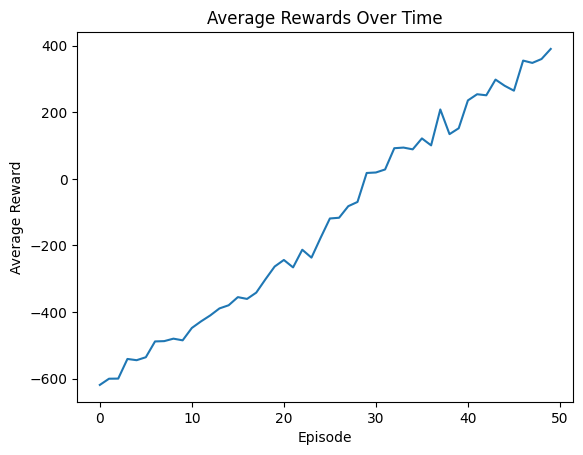

('lagrange multiplier:', tensor(0.7057), 'grad_norm:', tensor(0.1425))
fval before 4.8849813083506885e-18
a/e/r 0.01438035891144112 0.014369819899743258 1.0007334129287209
fval after -0.014380358911441115
Episode 51	Last reward: 255.7984588949875	Average reward 374.67
('lagrange multiplier:', tensor(0.6751), 'grad_norm:', tensor(0.1447))
fval before 2.6201263381153693e-17
a/e/r 0.01357169227295417 0.013813658995223983 0.9824835170497931
fval after -0.013571692272954143
Episode 52	Last reward: 498.6101953822961	Average reward 454.26
('lagrange multiplier:', tensor(0.7089), 'grad_norm:', tensor(0.1323))
fval before 1.1546319456101627e-17
a/e/r 0.013368864888758538 0.013449993759602624 0.9939681108932735
fval after -0.013368864888758526
Episode 53	Last reward: 361.63056879715174	Average reward 379.58
('lagrange multiplier:', tensor(0.7852), 'grad_norm:', tensor(0.1949))
fval before 4.440892098500626e-18
a/e/r 0.01566560483308746 0.015856843574956585 0.9879396715389716
fval after -0.015665

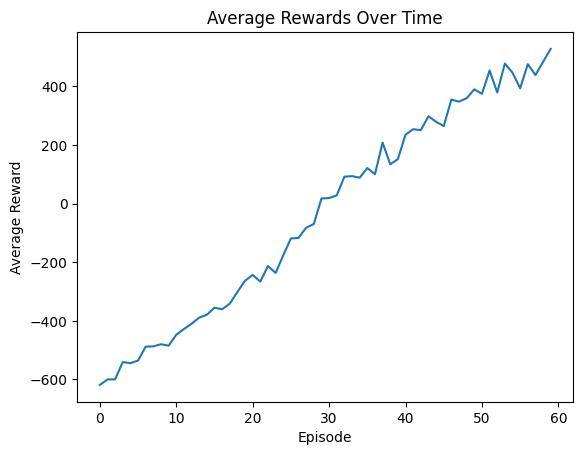

('lagrange multiplier:', tensor(0.6747), 'grad_norm:', tensor(0.1615))
fval before -7.993605777301126e-18
a/e/r 0.014044809823771794 0.014084911056094045 0.9971528941743015
fval after -0.014044809823771803
Episode 61	Last reward: 452.23815701318665	Average reward 435.69
('lagrange multiplier:', tensor(0.6976), 'grad_norm:', tensor(0.1396))
fval before 1.0658141036401503e-17
a/e/r 0.013786512410385685 0.01384895980386094 0.9954908242669716
fval after -0.013786512410385674
Episode 62	Last reward: 615.4596376551198	Average reward 496.75
('lagrange multiplier:', tensor(0.6896), 'grad_norm:', tensor(0.1514))
fval before -3.552713678800501e-18
a/e/r 0.014161221584414385 0.014268185749182823 0.9925033100459486
fval after -0.014161221584414388
Episode 63	Last reward: 669.6817354806818	Average reward 567.80
('lagrange multiplier:', tensor(0.7133), 'grad_norm:', tensor(0.1699))
fval before 1.0880185641326535e-17
a/e/r 0.014434452843089942 0.014682028438692766 0.9831375074202712
fval after -0.014

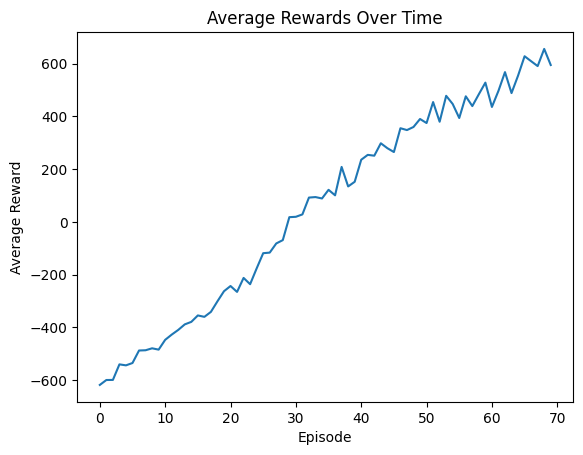

('lagrange multiplier:', tensor(0.7498), 'grad_norm:', tensor(0.2247))
fval before 5.10702591327572e-18
a/e/r 0.015034770846470907 0.015367400374343145 0.9783548603036605
fval after -0.015034770846470901
Episode 71	Last reward: 755.9214368694478	Average reward 692.70
('lagrange multiplier:', tensor(0.6955), 'grad_norm:', tensor(0.1579))
fval before 8.881784197001253e-19
a/e/r 0.013151840128824999 0.013506318539577037 0.9737546238293341
fval after -0.013151840128824997
Episode 72	Last reward: 806.0535909870343	Average reward 679.80
('lagrange multiplier:', tensor(0.7575), 'grad_norm:', tensor(0.1988))
fval before -7.327471962526034e-18
a/e/r 0.01517693174546935 0.015764641048715257 0.9627197789388423
fval after -0.015176931745469358
Episode 73	Last reward: 833.29594901868	Average reward 546.06
('lagrange multiplier:', tensor(0.7588), 'grad_norm:', tensor(0.1786))
fval before -1.0658141036401503e-17
a/e/r 0.015821743036881157 0.01569538019429729 1.0080509577353074
fval after -0.015821743

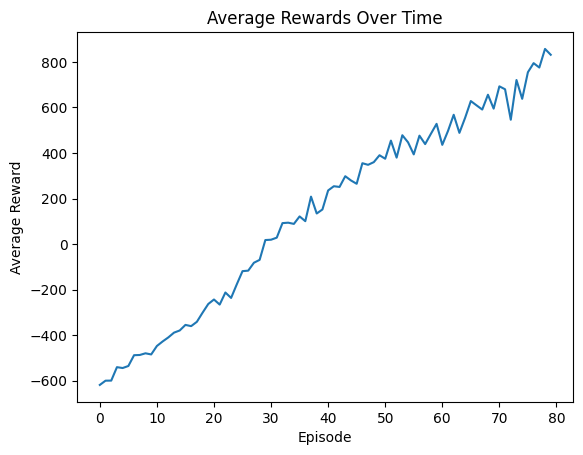

('lagrange multiplier:', tensor(0.7396), 'grad_norm:', tensor(0.2399))
fval before 1.1546319456101627e-17
a/e/r 0.014006353611863004 0.014483778445507764 0.9670372730816774
fval after -0.014006353611862992
Episode 81	Last reward: 1153.0435335509908	Average reward 826.82
('lagrange multiplier:', tensor(0.7111), 'grad_norm:', tensor(0.1927))
fval before 1.1546319456101627e-17
a/e/r 0.014203917103925282 0.014687244597383232 0.967092023949539
fval after -0.01420391710392527
Episode 82	Last reward: 776.0982813737236	Average reward 760.65
('lagrange multiplier:', tensor(0.6686), 'grad_norm:', tensor(0.1893))
fval before -1.3766765505351941e-17
a/e/r 0.012782440754782963 0.012946398350665016 0.9873356595833751
fval after -0.012782440754782977
Episode 83	Last reward: 720.7623799906092	Average reward 783.59
('lagrange multiplier:', tensor(0.6602), 'grad_norm:', tensor(0.1827))
fval before 7.549516567451065e-18
a/e/r 0.012797354608648578 0.013123014212467218 0.9751840851083393
fval after -0.0127

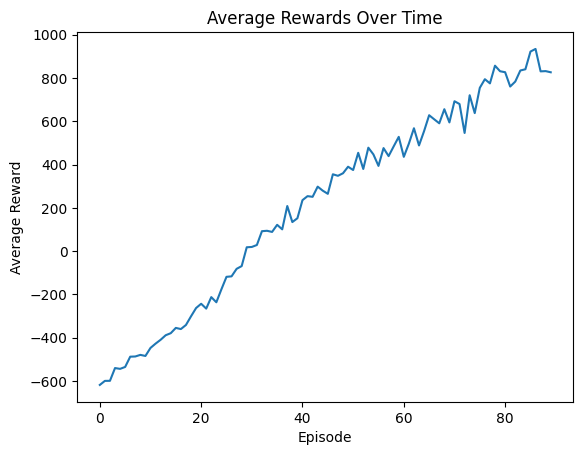

('lagrange multiplier:', tensor(0.7115), 'grad_norm:', tensor(0.1979))
fval before -1.865174681370263e-17
a/e/r 0.014282421095336792 0.014512097070997884 0.9841734813006389
fval after -0.014282421095336811
Episode 91	Last reward: 1061.9605748564202	Average reward 984.23
('lagrange multiplier:', tensor(0.6540), 'grad_norm:', tensor(0.1957))
fval before -7.105427357601002e-18
a/e/r 0.01240397581035947 0.012621779303593568 0.9827438360317323
fval after -0.012403975810359477
Episode 92	Last reward: 1028.170257528347	Average reward 960.64
('lagrange multiplier:', tensor(0.6940), 'grad_norm:', tensor(0.2075))
fval before -7.771561172376097e-18
a/e/r 0.013148525706634906 0.013702733192435703 0.9595549677558682
fval after -0.013148525706634913
Episode 93	Last reward: 784.0651860512789	Average reward 921.03
('lagrange multiplier:', tensor(0.7637), 'grad_norm:', tensor(0.2816))
fval before -1.3322676295501878e-17
a/e/r 0.01554733170424339 0.015902874422296005 0.9776428645154778
fval after -0.015

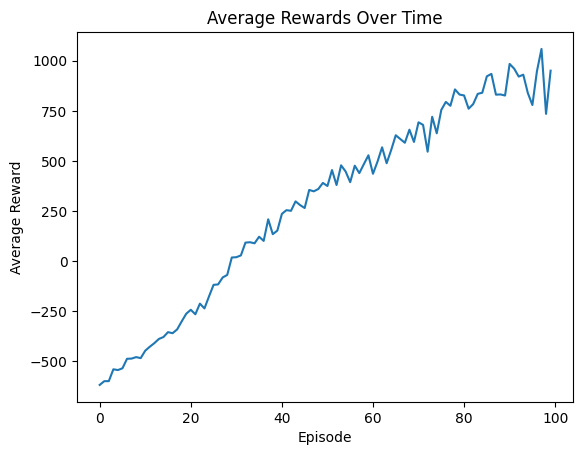

('lagrange multiplier:', tensor(0.6003), 'grad_norm:', tensor(0.1859))
fval before -8.881784197001253e-19
a/e/r 0.01249823572006991 0.01233204450010161 1.013476372061983
fval after -0.012498235720069912
Episode 101	Last reward: 1028.973151126624	Average reward 926.32
('lagrange multiplier:', tensor(0.5652), 'grad_norm:', tensor(0.1957))
fval before 1.1546319456101627e-17
a/e/r 0.011801464773382984 0.01202823327271112 0.9811469819227222
fval after -0.011801464773382972
Episode 102	Last reward: 1214.7051117528824	Average reward 1093.01
('lagrange multiplier:', tensor(0.6894), 'grad_norm:', tensor(0.2072))
fval before -1.5987211554602253e-17
a/e/r 0.013322013491658782 0.013673183980343026 0.9743168460843431
fval after -0.013322013491658798
Episode 103	Last reward: 1000.6747269761601	Average reward 1013.51
('lagrange multiplier:', tensor(0.6863), 'grad_norm:', tensor(0.2864))
fval before -1.687538997430238e-17
a/e/r 0.013741574977388756 0.014299589291716718 0.9609768992000909
fval after -0

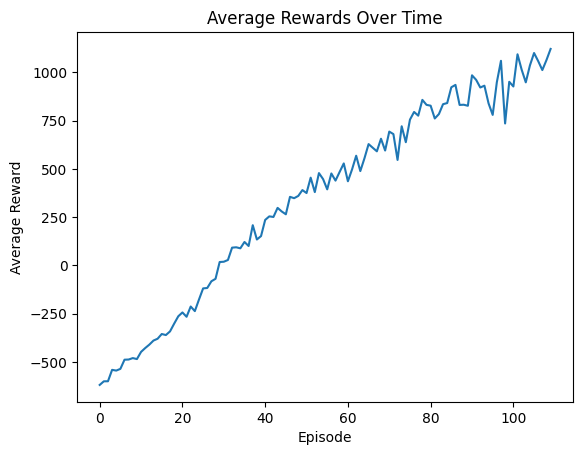

('lagrange multiplier:', tensor(0.6785), 'grad_norm:', tensor(0.2218))
fval before 7.105427357601002e-18
a/e/r 0.013404262107564555 0.013596704385117023 0.9858464027677828
fval after -0.013404262107564548
Episode 111	Last reward: 1129.6431242732988	Average reward 1095.07
('lagrange multiplier:', tensor(0.6594), 'grad_norm:', tensor(0.2062))
fval before 9.547918011776345e-18
a/e/r 0.012575359876354681 0.01295702512390127 0.9705437595515234
fval after -0.01257535987635467
Episode 112	Last reward: 1179.7003009264333	Average reward 1047.67
('lagrange multiplier:', tensor(0.7139), 'grad_norm:', tensor(0.2180))
fval before -9.880984919163893e-18
a/e/r 0.012984840761044229 0.01371330160868635 0.9468792513700205
fval after -0.012984840761044239
Episode 113	Last reward: 1015.9770062556727	Average reward 1134.70
('lagrange multiplier:', tensor(0.7362), 'grad_norm:', tensor(0.2227))
fval before 6.661338147750939e-18
a/e/r 0.013877493036912977 0.014491218269438692 0.9576484722599181
fval after -0.

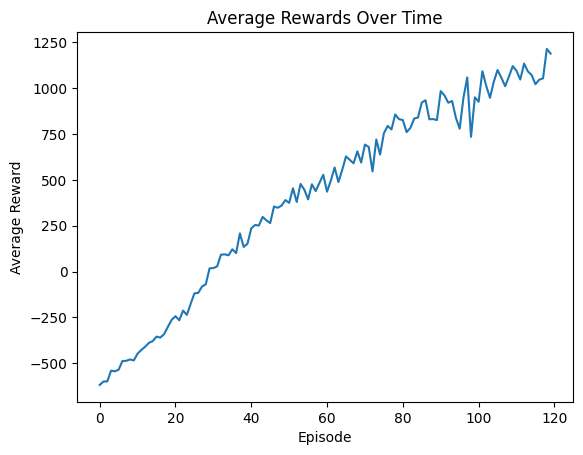

('lagrange multiplier:', tensor(0.6445), 'grad_norm:', tensor(0.2120))
fval before 1.1102230246251566e-17
a/e/r 0.012591409312227337 0.01273352043042434 0.9888396049644327
fval after -0.012591409312227327
Episode 121	Last reward: 1123.0419794319132	Average reward 1132.34
('lagrange multiplier:', tensor(0.6761), 'grad_norm:', tensor(0.2403))
fval before -1.2434497875801754e-17
a/e/r 0.012703218136722134 0.01310724163048037 0.9691755515654267
fval after -0.012703218136722146
Episode 122	Last reward: 1076.9536409313632	Average reward 1175.03
('lagrange multiplier:', tensor(0.7078), 'grad_norm:', tensor(0.2283))
fval before -1.021405182655144e-17
a/e/r 0.013475695173356873 0.013962363868254586 0.9651442478157854
fval after -0.013475695173356884
Episode 123	Last reward: 1123.2660870678005	Average reward 1185.84
('lagrange multiplier:', tensor(0.7468), 'grad_norm:', tensor(0.2780))
fval before -1.7763568394002505e-18
a/e/r 0.014682474988073284 0.015113987088676527 0.9714494859581736
fval aft

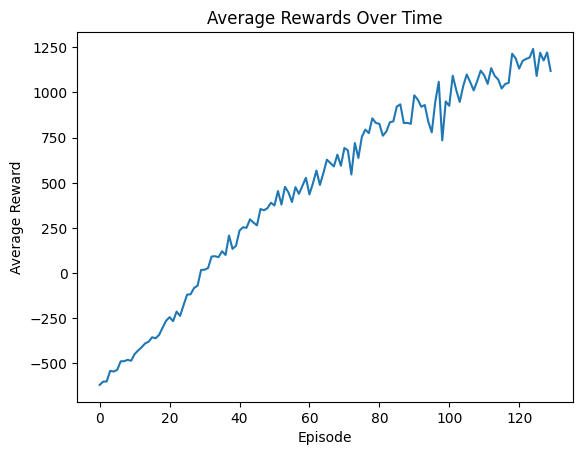

('lagrange multiplier:', tensor(0.8256), 'grad_norm:', tensor(0.3091))
fval before 6.217248937900877e-18
a/e/r 0.015892386590120443 0.01631500401775165 0.9740963945107599
fval after -0.015892386590120437
Episode 131	Last reward: 1277.7986008293276	Average reward 1251.14
('lagrange multiplier:', tensor(0.6711), 'grad_norm:', tensor(0.2442))
fval before -6.661338147750939e-18
a/e/r 0.012692013529497375 0.01334863224647256 0.9508100376989036
fval after -0.012692013529497382
Episode 132	Last reward: 1230.3559231085414	Average reward 1303.42
('lagrange multiplier:', tensor(0.6663), 'grad_norm:', tensor(0.2546))
fval before -1.021405182655144e-17
a/e/r 0.013663346132809142 0.01402866089818931 0.9739593986887716
fval after -0.013663346132809152
Episode 133	Last reward: 1282.0868691680487	Average reward 1194.58
('lagrange multiplier:', tensor(0.7251), 'grad_norm:', tensor(0.2525))
fval before 7.771561172376097e-18
a/e/r 0.01483677819780073 0.015191176293148454 0.9766707930637627
fval after -0.

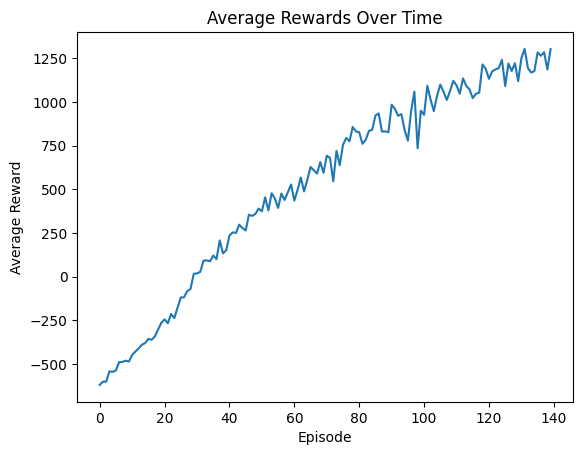

('lagrange multiplier:', tensor(0.6553), 'grad_norm:', tensor(0.2261))
fval before 2.220446049250313e-18
a/e/r 0.012577528164017575 0.012914458470579093 0.9739106128740054
fval after -0.012577528164017573
Episode 141	Last reward: 1347.2651997155067	Average reward 1298.02
('lagrange multiplier:', tensor(0.6908), 'grad_norm:', tensor(0.2423))
fval before -7.549516567451065e-18
a/e/r 0.013083020494494323 0.013674180516602765 0.9567681572295558
fval after -0.01308302049449433
Episode 142	Last reward: 1121.697908103096	Average reward 1223.36
('lagrange multiplier:', tensor(0.7197), 'grad_norm:', tensor(0.3348))
fval before -1.1324274851176596e-17
a/e/r 0.014057957995783719 0.014377629827208763 0.9777660271361219
fval after -0.014057957995783731
Episode 143	Last reward: 1468.1922497189655	Average reward 1318.42
('lagrange multiplier:', tensor(0.6029), 'grad_norm:', tensor(0.2478))
fval before -1.3322676295501879e-18
a/e/r 0.011484783318442488 0.01182105829554538 0.9715528873392314
fval after

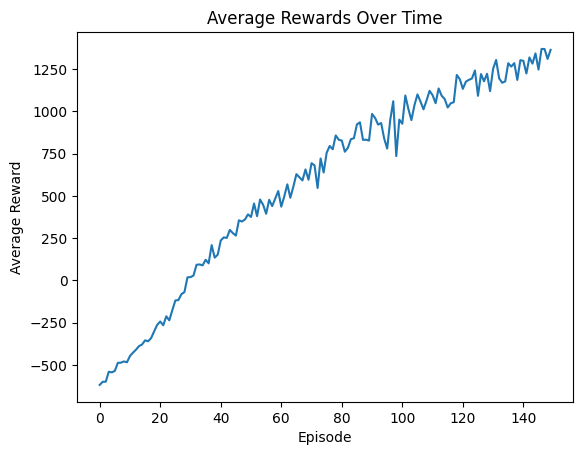

('lagrange multiplier:', tensor(0.6309), 'grad_norm:', tensor(0.2607))
fval before -1.354472090042691e-17
a/e/r 0.013076032755151361 0.013344264374560938 0.9798991078203663
fval after -0.013076032755151375
Episode 151	Last reward: 1458.1041602735474	Average reward 1386.93
('lagrange multiplier:', tensor(0.6786), 'grad_norm:', tensor(0.2944))
fval before 2.1094237467877974e-18
a/e/r 0.01316693090361 0.01377089938177784 0.9561416824403616
fval after -0.013166930903609998
Episode 152	Last reward: 1305.693730397136	Average reward 1395.23
('lagrange multiplier:', tensor(0.7863), 'grad_norm:', tensor(0.2864))
fval before -8.881784197001253e-19
a/e/r 0.014747531355558608 0.015250553997546483 0.9670161069513408
fval after -0.01474753135555861
Episode 153	Last reward: 1612.7360683142263	Average reward 1441.28
('lagrange multiplier:', tensor(0.7241), 'grad_norm:', tensor(0.2987))
fval before 9.325873406851316e-18
a/e/r 0.014963520427852635 0.015201385737239378 0.9843523930319039
fval after -0.01

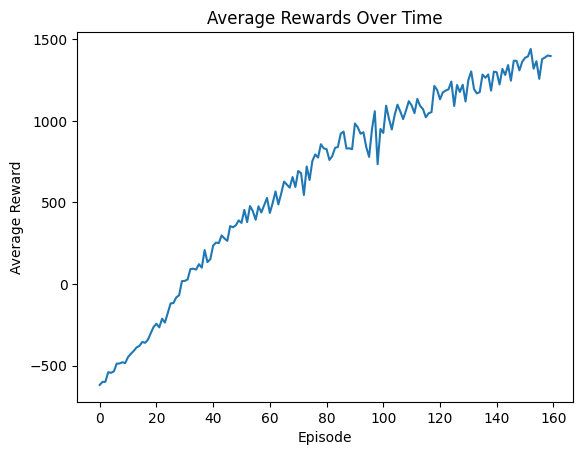

('lagrange multiplier:', tensor(0.5483), 'grad_norm:', tensor(0.2418))
fval before -6.661338147750939e-18
a/e/r 0.010799555841622462 0.011090769500954013 0.9737427002421697
fval after -0.010799555841622469
Episode 161	Last reward: 1441.0986408347255	Average reward 1398.76
('lagrange multiplier:', tensor(0.6698), 'grad_norm:', tensor(0.3282))
fval before 3.552713678800501e-18
a/e/r 0.013602229982186898 0.013957062515875992 0.9745768471492138
fval after -0.013602229982186895
Episode 162	Last reward: 1584.3346249349938	Average reward 1414.79
('lagrange multiplier:', tensor(0.6589), 'grad_norm:', tensor(0.3139))
fval before -9.769962616701377e-18
a/e/r 0.013361123522481425 0.013915262308086842 0.9601776255929161
fval after -0.013361123522481436
Episode 163	Last reward: 1252.169405203965	Average reward 1425.04
('lagrange multiplier:', tensor(0.5896), 'grad_norm:', tensor(0.2934))
fval before 1.2434497875801754e-17
a/e/r 0.01231480099426935 0.01257528494591041 0.9792860398184637
fval after -

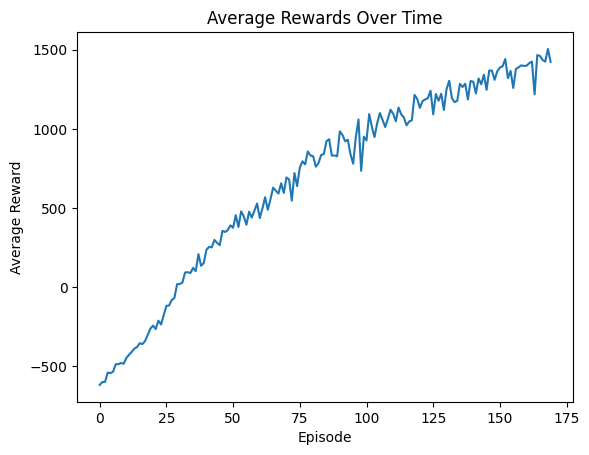

('lagrange multiplier:', tensor(0.6464), 'grad_norm:', tensor(0.2584))
fval before 8.881784197001253e-18
a/e/r 0.012300909815875614 0.012588408051640364 0.9771616685298593
fval after -0.012300909815875605
Episode 171	Last reward: 1459.946494369547	Average reward 1432.41
('lagrange multiplier:', tensor(0.5944), 'grad_norm:', tensor(0.3010))
fval before 8.881784197001253e-19
a/e/r 0.01240223349573194 0.012828941350414349 0.9667386541860973
fval after -0.012402233495731938
Episode 172	Last reward: 1506.4027497977713	Average reward 1443.21
('lagrange multiplier:', tensor(0.6503), 'grad_norm:', tensor(0.2907))
fval before -1.2434497875801754e-17
a/e/r 0.013471984301916363 0.013691551825421536 0.9839632843446208
fval after -0.013471984301916375
Episode 173	Last reward: 1661.740037023207	Average reward 1356.31
('lagrange multiplier:', tensor(0.6034), 'grad_norm:', tensor(0.2364))
fval before 7.105427357601002e-18
a/e/r 0.011728111005442738 0.012032088408047063 0.9747361062938147
fval after -0

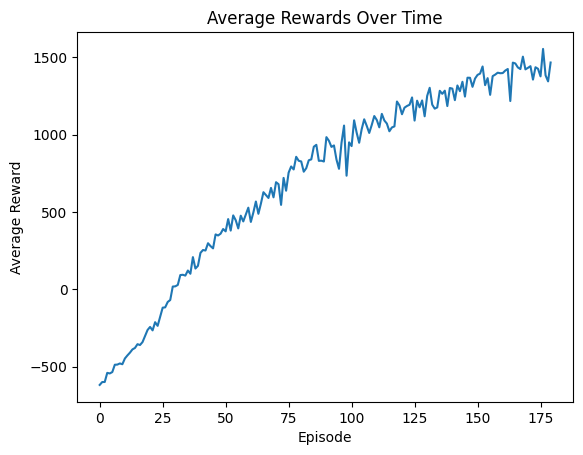

('lagrange multiplier:', tensor(0.6829), 'grad_norm:', tensor(0.3425))
fval before 1.7319479184152442e-17
a/e/r 0.01400927120310149 0.014335764459409516 0.9772252636242411
fval after -0.014009271203101473
Episode 181	Last reward: 1524.5480363905097	Average reward 1431.44
('lagrange multiplier:', tensor(0.5778), 'grad_norm:', tensor(0.2809))
fval before -8.881784197001253e-18
a/e/r 0.011198125301619996 0.011481016228146198 0.9753601143919052
fval after -0.011198125301620005
Episode 182	Last reward: 1602.100890212376	Average reward 1543.47
('lagrange multiplier:', tensor(0.6550), 'grad_norm:', tensor(0.2956))
fval before -4.440892098500626e-18
a/e/r 0.012969148851253458 0.01340292004107663 0.9676360682229118
fval after -0.012969148851253463
Episode 183	Last reward: 1481.451498979553	Average reward 1436.25
('lagrange multiplier:', tensor(0.6324), 'grad_norm:', tensor(0.2924))
fval before 8.881784197001253e-18
a/e/r 0.012184090633740664 0.012318017883264277 0.9891275324656273
fval after -0

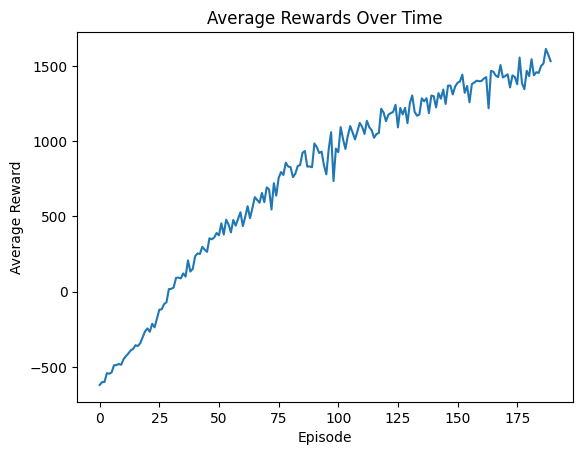

('lagrange multiplier:', tensor(0.6721), 'grad_norm:', tensor(0.3251))
fval before 8.881784197001253e-18
a/e/r 0.01302386267625235 0.013537851912244799 0.9620331763617865
fval after -0.013023862676252341
Episode 191	Last reward: 1510.6039043798546	Average reward 1533.62
('lagrange multiplier:', tensor(0.5989), 'grad_norm:', tensor(0.2885))
fval before 1.7763568394002505e-17
a/e/r 0.01185559922199168 0.012539270472292816 0.9454775896403385
fval after -0.011855599221991663
Episode 192	Last reward: 1384.9337674177525	Average reward 1401.85
('lagrange multiplier:', tensor(0.6614), 'grad_norm:', tensor(0.3047))
fval before 2.020605904817785e-17
a/e/r 0.012838158603630002 0.013089885850116226 0.9807693321875691
fval after -0.012838158603629982
Episode 193	Last reward: 1461.7825658646107	Average reward 1529.38
('lagrange multiplier:', tensor(0.6068), 'grad_norm:', tensor(0.2914))
fval before 2.220446049250313e-18
a/e/r 0.011457874687731308 0.011664422954414748 0.9822924573731043
fval after -0

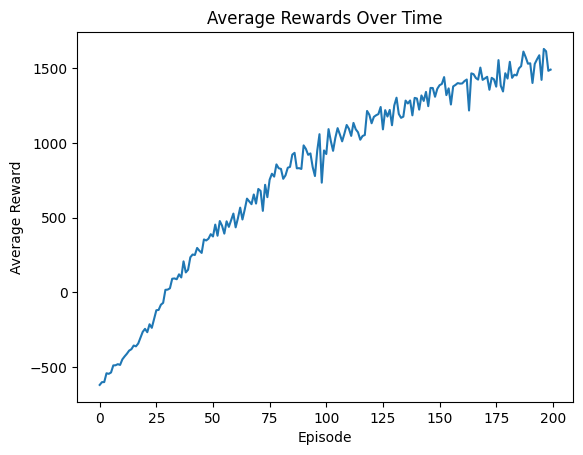

('lagrange multiplier:', tensor(0.6874), 'grad_norm:', tensor(0.3006))
fval before -9.992007221626408e-18
a/e/r 0.014140223105286905 0.01453534122681516 0.9728167288705041
fval after -0.014140223105286915
Episode 201	Last reward: 1599.7461654796582	Average reward 1382.16
('lagrange multiplier:', tensor(0.6467), 'grad_norm:', tensor(0.3008))
fval before -1.2434497875801754e-17
a/e/r 0.013260236256577785 0.01355609834796554 0.9781749819311278
fval after -0.013260236256577797
Episode 202	Last reward: 1474.9444043398594	Average reward 1610.21
('lagrange multiplier:', tensor(0.7486), 'grad_norm:', tensor(0.4085))
fval before 9.769962616701377e-18
a/e/r 0.01423306376151143 0.01450976464352316 0.9809300227254035
fval after -0.014233063761511419
Episode 203	Last reward: 1499.2429119428225	Average reward 1584.57
('lagrange multiplier:', tensor(0.6222), 'grad_norm:', tensor(0.2837))
fval before -1.1546319456101627e-17
a/e/r 0.0116567827908506 0.012174941576721398 0.957440552580431
fval after -0.

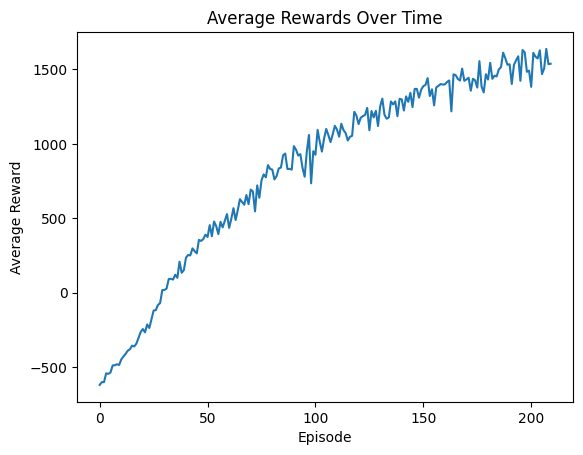

('lagrange multiplier:', tensor(0.5994), 'grad_norm:', tensor(0.2637))
fval before -1.0658141036401503e-17
a/e/r 0.011377469274232666 0.011615882233904518 0.979475260262542
fval after -0.011377469274232676
Episode 211	Last reward: 1591.615479891338	Average reward 1602.73
('lagrange multiplier:', tensor(0.6107), 'grad_norm:', tensor(0.2631))
fval before -1.9539925233402754e-17
a/e/r 0.012290063389409278 0.012632087615264007 0.9729241724510014
fval after -0.012290063389409297
Episode 212	Last reward: 1662.8255526917085	Average reward 1598.70
('lagrange multiplier:', tensor(0.5016), 'grad_norm:', tensor(0.2583))
fval before 5.3290705182007515e-18
a/e/r 0.010382038851228232 0.010780877698828184 0.9630049742941335
fval after -0.010382038851228226
Episode 213	Last reward: 1063.0012675799067	Average reward 1586.56
('lagrange multiplier:', tensor(0.6640), 'grad_norm:', tensor(0.3750))
fval before -2.220446049250313e-18
a/e/r 0.013500963273657766 0.014116838610194747 0.9563729986902156
fval aft

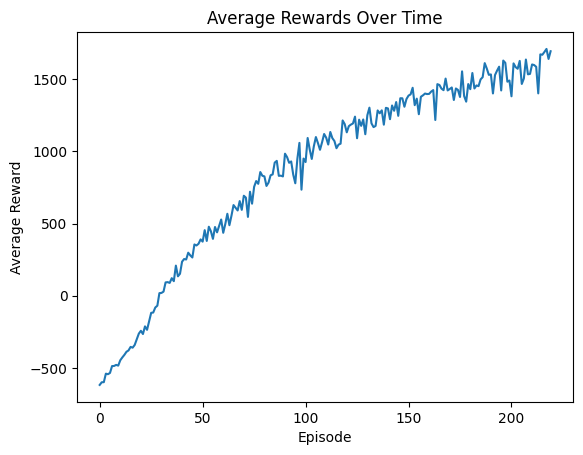

('lagrange multiplier:', tensor(0.7699), 'grad_norm:', tensor(0.3716))
fval before 6.661338147750939e-18
a/e/r 0.014653056815784644 0.015332072734864777 0.9557127121151684
fval after -0.014653056815784637
Episode 221	Last reward: 1820.7449726851423	Average reward 1470.22
('lagrange multiplier:', tensor(0.6549), 'grad_norm:', tensor(0.3332))
fval before 5.3290705182007515e-18
a/e/r 0.01255460494796821 0.013211845431733349 0.9502536956581007
fval after -0.012554604947968204
Episode 222	Last reward: 1693.2325010841175	Average reward 1548.10
('lagrange multiplier:', tensor(0.6208), 'grad_norm:', tensor(0.3997))
fval before -6.217248937900877e-18
a/e/r 0.012650883691115515 0.012921247670743007 0.9790760159918872
fval after -0.012650883691115522
Episode 223	Last reward: 1538.2427550338666	Average reward 1702.82
('lagrange multiplier:', tensor(0.6728), 'grad_norm:', tensor(0.3626))
fval before -5.3290705182007515e-18
a/e/r 0.01363547778747333 0.014271447753783386 0.955437599794915
fval after 

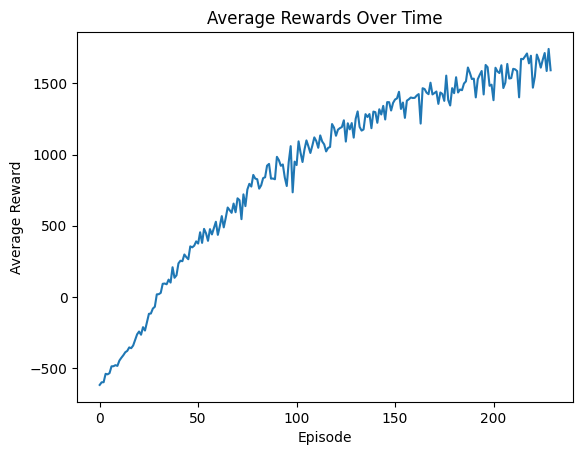

('lagrange multiplier:', tensor(0.6338), 'grad_norm:', tensor(0.2965))
fval before 3.552713678800501e-18
a/e/r 0.011687893194111168 0.012672441803748942 0.9223079004910868
fval after -0.011687893194111164
Episode 231	Last reward: 1676.6097543420062	Average reward 1727.66
('lagrange multiplier:', tensor(0.6927), 'grad_norm:', tensor(0.4181))
fval before -7.549516567451065e-18
a/e/r 0.013826593657953351 0.014295759170219944 0.9671814902111718
fval after -0.013826593657953358
Episode 232	Last reward: 1732.8674663051056	Average reward 1647.24
('lagrange multiplier:', tensor(0.6958), 'grad_norm:', tensor(0.3207))
fval before -9.547918011776345e-18
a/e/r 0.013093412832060012 0.013474754175918677 0.9716995695149543
fval after -0.013093412832060022
Episode 233	Last reward: 1622.6935912646206	Average reward 1619.73
('lagrange multiplier:', tensor(0.6544), 'grad_norm:', tensor(0.3024))
fval before 9.325873406851316e-18
a/e/r 0.012467720723424202 0.012751376180093298 0.9777549142411842
fval after

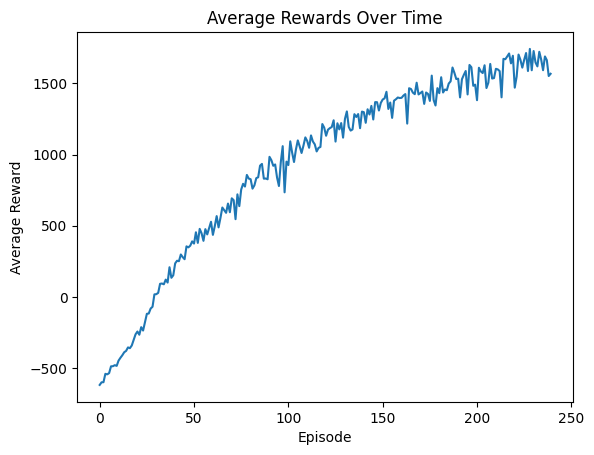

('lagrange multiplier:', tensor(0.5537), 'grad_norm:', tensor(0.3288))
fval before 4.440892098500626e-18
a/e/r 0.010600867517038093 0.010878684919749675 0.9744622254655781
fval after -0.010600867517038088
Episode 241	Last reward: 1994.0156717568113	Average reward 1729.12
('lagrange multiplier:', tensor(0.5137), 'grad_norm:', tensor(0.2725))
fval before 8.881784197001253e-19
a/e/r 0.010244927473887232 0.010727350969995145 0.9550286461720818
fval after -0.01024492747388723
Episode 242	Last reward: 1777.5305840365456	Average reward 1630.23
('lagrange multiplier:', tensor(0.5600), 'grad_norm:', tensor(0.2774))
fval before -1.4210854715202004e-17
a/e/r 0.010955208126895067 0.011160067118246105 0.9816435699552286
fval after -0.01095520812689508
Episode 243	Last reward: 1718.761156330611	Average reward 1738.15
('lagrange multiplier:', tensor(0.6963), 'grad_norm:', tensor(0.3861))
fval before -1.3322676295501879e-18
a/e/r 0.013614053563867131 0.014066292478167201 0.9678494589102277
fval after 

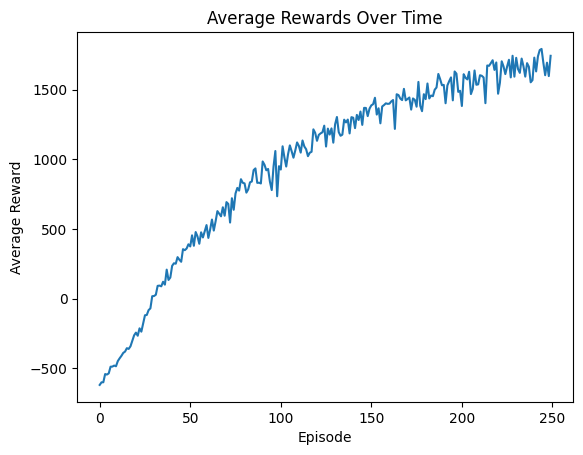

('lagrange multiplier:', tensor(0.6682), 'grad_norm:', tensor(0.3035))
fval before -2.220446049250313e-18
a/e/r 0.01274708539955707 0.013245150306606519 0.9623964322397293
fval after -0.012747085399557071
Episode 251	Last reward: 1697.884996289784	Average reward 1713.62
('lagrange multiplier:', tensor(0.5933), 'grad_norm:', tensor(0.3163))
fval before 1.7763568394002505e-18
a/e/r 0.011352411575020808 0.011829428460291714 0.9596754072377947
fval after -0.011352411575020807
Episode 252	Last reward: 1977.0680869191453	Average reward 1738.24
('lagrange multiplier:', tensor(0.5587), 'grad_norm:', tensor(0.2827))
fval before -8.43769498715119e-18
a/e/r 0.01114655943770222 0.011420034088798119 0.9760530792667117
fval after -0.011146559437702229
Episode 253	Last reward: 1976.3230609354175	Average reward 1774.92
('lagrange multiplier:', tensor(0.5782), 'grad_norm:', tensor(0.3262))
fval before 3.552713678800501e-18
a/e/r 0.011726889035106422 0.012303297470254505 0.9531500854513469
fval after -0

In [ ]:

from itertools import count
from matplotlib import animation
import matplotlib.pyplot as plt
import gym
import scipy.optimize
import torch
from torch.autograd import Variable


torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')



env = gym.make("HalfCheetah-v4")
gamma=0.995
tau=0.97
l2_reg=1e-3
max_kl=1e-2
damping=1e-1
batch_size=15000
log_interval=1
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

env.seed(100)
torch.manual_seed(100)

policy_net = Policy(num_inputs, num_actions)
value_net = Value(num_inputs)

def select_action(state):
    state = torch.from_numpy(state).unsqueeze(0)
    action_mean, _, action_std = policy_net(Variable(state))
    action = torch.normal(action_mean, action_std)
    return action

def update_params(batch):
    rewards = torch.Tensor(batch.reward)
    masks = torch.Tensor(batch.mask)
    actions = torch.Tensor(np.concatenate(batch.action, 0))
    states = torch.Tensor(batch.state)
    values = value_net(Variable(states))

    returns = torch.Tensor(actions.size(0),1)
    deltas = torch.Tensor(actions.size(0),1)
    advantages = torch.Tensor(actions.size(0),1)

    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        returns[i] = rewards[i] + gamma * prev_return * masks[i]
        deltas[i] = rewards[i] + gamma * prev_value * masks[i] - values.data[i]
        advantages[i] = deltas[i] + gamma *tau * prev_advantage * masks[i]

        prev_return = returns[i, 0]
        prev_value = values.data[i, 0]
        prev_advantage = advantages[i, 0]

    targets = Variable(returns)

    # Original code uses the same LBFGS to optimize the value loss
    def get_value_loss(flat_params):
        set_flat_params_to(value_net, torch.Tensor(flat_params))
        for param in value_net.parameters():
            if param.grad is not None:
                param.grad.data.fill_(0)

        values_ = value_net(Variable(states))

        value_loss = (values_ - targets).pow(2).mean()

        # weight decay
        for param in value_net.parameters():
            value_loss += param.pow(2).sum() *l2_reg
        value_loss.backward()
        return (value_loss.data.double().numpy(), get_flat_grad_from(value_net).data.double().numpy())

    flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(value_net).double().numpy(), maxiter=25)
    set_flat_params_to(value_net, torch.Tensor(flat_params))

    advantages = (advantages - advantages.mean()) / advantages.std()

    action_means, action_log_stds, action_stds = policy_net(Variable(states))
    fixed_log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds).data.clone()

    def get_loss(volatile=False):
        if volatile:
            with torch.no_grad():
                action_means, action_log_stds, action_stds = policy_net(Variable(states))
        else:
            action_means, action_log_stds, action_stds = policy_net(Variable(states))

        log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds)
        action_loss = -Variable(advantages) * torch.exp(log_prob - Variable(fixed_log_prob))
        return action_loss.mean()


    def get_kl():
        mean1, log_std1, std1 = policy_net(Variable(states))

        mean0 = Variable(mean1.data)
        log_std0 = Variable(log_std1.data)
        std0 = Variable(std1.data)
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)

    trpo_step(policy_net, get_loss, get_kl, max_kl, damping)

running_state = ZFilter((num_inputs,), clip=5)
running_reward = ZFilter((1,), demean=False, clip=10)
average_rewards=[]
frames=[]
for i_episode in count(1):
    memory = Memory()

    num_steps = 0
    reward_batch = 0
    num_episodes = 0
    while num_steps < batch_size:
        state = env.reset()
        state = running_state(state)

        reward_sum = 0
        for t in range(10000): # Don't infinite loop while learning
            action = select_action(state)
            action = action.data[0].numpy()
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward

            next_state = running_state(next_state)

            mask = 1
            if done:
                mask = 0

            memory.push(state, np.array([action]), mask, next_state, reward)

            #if render:
                #env.render()
            if done:
                break

            state = next_state
        num_steps += (t-1)
        num_episodes += 1
        reward_batch += reward_sum

    reward_batch /= num_episodes
    batch = memory.sample()
    update_params(batch)
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {}\tAverage reward {:.2f}'.format(
            i_episode, reward_sum, reward_batch))
        average_rewards.append(reward_batch)
        if i_episode % 10 == 0:
            plt.plot(average_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Average Reward')
            plt.title('Average Rewards Over Time')
            plt.savefig("Training_plot.png")
            plt.show()


In [ ]:

from itertools import count
from matplotlib import animation
import matplotlib.pyplot as plt
import gym
import scipy.optimize
import torch
from torch.autograd import Variable


torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')



#env = gym.make(args.env_name)
gamma=0.995
tau=0.97
l2_reg=1e-3
max_kl=1e-2
damping=1e-1
batch_size=15000
log_interval=1
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

env.seed(100)
torch.manual_seed(100)

policy_net = Policy(num_inputs, num_actions)
value_net = Value(num_inputs)

def select_action(state):
    state = torch.from_numpy(state).unsqueeze(0)
    action_mean, _, action_std = policy_net(Variable(state))
    action = torch.normal(action_mean, action_std)
    return action

def update_params(batch):
    rewards = torch.Tensor(batch.reward)
    masks = torch.Tensor(batch.mask)
    actions = torch.Tensor(np.concatenate(batch.action, 0))
    states = torch.Tensor(batch.state)
    values = value_net(Variable(states))

    returns = torch.Tensor(actions.size(0),1)
    deltas = torch.Tensor(actions.size(0),1)
    advantages = torch.Tensor(actions.size(0),1)

    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        returns[i] = rewards[i] + gamma * prev_return * masks[i]
        deltas[i] = rewards[i] + gamma * prev_value * masks[i] - values.data[i]
        advantages[i] = deltas[i] + gamma *tau * prev_advantage * masks[i]

        prev_return = returns[i, 0]
        prev_value = values.data[i, 0]
        prev_advantage = advantages[i, 0]

    targets = Variable(returns)

    # Original code uses the same LBFGS to optimize the value loss
    def get_value_loss(flat_params):
        set_flat_params_to(value_net, torch.Tensor(flat_params))
        for param in value_net.parameters():
            if param.grad is not None:
                param.grad.data.fill_(0)

        values_ = value_net(Variable(states))

        value_loss = (values_ - targets).pow(2).mean()

        # weight decay
        for param in value_net.parameters():
            value_loss += param.pow(2).sum() *l2_reg
        value_loss.backward()
        return (value_loss.data.double().numpy(), get_flat_grad_from(value_net).data.double().numpy())

    flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(value_net).double().numpy(), maxiter=25)
    set_flat_params_to(value_net, torch.Tensor(flat_params))

    advantages = (advantages - advantages.mean()) / advantages.std()

    action_means, action_log_stds, action_stds = policy_net(Variable(states))
    fixed_log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds).data.clone()

    def get_loss(volatile=False):
        if volatile:
            with torch.no_grad():
                action_means, action_log_stds, action_stds = policy_net(Variable(states))
        else:
            action_means, action_log_stds, action_stds = policy_net(Variable(states))

        log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds)
        action_loss = -Variable(advantages) * torch.exp(log_prob - Variable(fixed_log_prob))
        return action_loss.mean()


    def get_kl():
        mean1, log_std1, std1 = policy_net(Variable(states))

        mean0 = Variable(mean1.data)
        log_std0 = Variable(log_std1.data)
        std0 = Variable(std1.data)
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)

    trpo_step(policy_net, get_loss, get_kl, max_kl, damping)

running_state = ZFilter((num_inputs,), clip=5)
running_reward = ZFilter((1,), demean=False, clip=10)
average_rewards=[]
frames=[]
for i_episode in count(1):
    memory = Memory()

    num_steps = 0
    reward_batch = 0
    num_episodes = 0
    while num_steps < batch_size:
        state = env.reset()
        state = running_state(state)

        reward_sum = 0
        for t in range(10000): # Don't infinite loop while learning
            action = select_action(state)
            action = action.data[0].numpy()
            next_state, reward, done, _ = env.step(action)
            reward_sum += reward

            next_state = running_state(next_state)

            mask = 1
            if done:
                mask = 0

            memory.push(state, np.array([action]), mask, next_state, reward)

            #if render:
                #env.render()
            if done:
                break

            state = next_state
        num_steps += (t-1)
        num_episodes += 1
        reward_batch += reward_sum

    reward_batch /= num_episodes
    batch = memory.sample()
    update_params(batch)
    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {}\tAverage reward {:.2f}'.format(
            i_episode, reward_sum, reward_batch))
        average_rewards.append(reward_batch)
        if i_episode % 10 == 0:
            plt.plot(average_rewards)
            plt.xlabel('Episode')
            plt.ylabel('Average Reward')
            plt.title('Average Rewards Over Time')
            plt.savefig("Training_plot.png")
            plt.show()


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:749: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


NameError: name 'env' is not defined